In [36]:
import os 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random

SEED = 31
random.seed(SEED)
np.random.seed(SEED)

In [42]:
# Read the algorithm selection results
df = pd.read_csv('algorithm_selection_data_seed_123/algorithm_selection_labels.csv')

# Create label encoder for target variable
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['best_algorithm'])

# Create final dataframe with dataset names as index and encoded targets
target_df = df[['dataset', 'target']].copy()
target_df.set_index('dataset', inplace=True)

# Get majority class (most common best algorithm)
majority_algorithm = df['best_algorithm'].value_counts().idxmax()
majority_count = df['best_algorithm'].value_counts().max()
total_datasets = len(df)
majority_accuracy = majority_count / total_datasets  # <- saved as variable

# Store in variable
majority_classifier = {
    'algorithm_name': majority_algorithm,
    'encoded_label': label_encoder.transform([majority_algorithm])[0],
    'count': majority_count,
    'accuracy': majority_accuracy
}

# Print encoding mapping for reference
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Algorithm encoding mapping:")
for algo, code in mapping.items():
    print(f"  {algo}: {code}")

print(f"\nTarget distribution:")
print(target_df['target'].value_counts().sort_index())

# Show majority class info
print(f"\nMajority classifier: {majority_classifier['algorithm_name']} (encoded as {majority_classifier['encoded_label']})")
print(f"Appears in {majority_classifier['count']} out of {total_datasets} datasets")
print(f"Majority baseline accuracy: {majority_accuracy:.4f}")

# Display first few rows
print(f"\nFirst 10 rows:")
print(target_df.head(10))

# Save for later joining with meta-features
target_df.to_csv('algorithm_targets.csv', index=True)
print(f"\nSaved target encodings to 'algorithm_targets.csv'")
print(f"Shape: {target_df.shape}")


Algorithm encoding mapping:
  DecisionTree: 0
  GradientBoosting: 1
  RandomForest: 2
  SVC: 3

Target distribution:
target
0     3
1    21
2    50
3    46
Name: count, dtype: int64

Majority classifier: RandomForest (encoded as 2)
Appears in 50 out of 120 datasets
Majority baseline accuracy: 0.4167

First 10 rows:
                            target
dataset                           
synthetic-control                3
chess-krvkp                      0
balance-scale                    3
statlog-german-credit            3
acute-nephritis                  3
pittsburg-bridges-MATERIAL       3
musk-1                           1
cylinder-bands                   2
low-res-spect                    2
balloons                         1

Saved target encodings to 'algorithm_targets.csv'
Shape: (120, 1)


In [43]:
# Load targets once
targets = pd.read_csv('algorithm_targets.csv', index_col=0)

# List of all meta-feature files (5 splits + mf1 + mf2 = 7 total)
metafeature_files = [
    'metafeatures/meta-features-split-0.csv',  # x1
    'metafeatures/meta-features-split-1.csv',  # x2
    'metafeatures/meta-features-split-2.csv',  # x3
    'metafeatures/meta-features-split-3.csv',  # x4
    'metafeatures/meta-features-split-4.csv',  # x5
    'metafeatures/mf1.csv',                    # x6
    'metafeatures/mf2.csv'                     # x7
]

# Create x1 to x7 datasets
datasets = {}

for i, file_path in enumerate(metafeature_files, 1):
    print(f"Creating x{i} from {file_path}...")
    
    # Load meta-features
    meta_features = pd.read_csv(file_path, index_col=0)
    
    # Join with targets
    final_df = meta_features.join(targets)
    
    # Store as x1, x2, ..., x7
    datasets[f'x{i}'] = final_df
    
    print(f"  x{i} shape: {final_df.shape}")

# Now you have x1, x2, x3, x4, x5, x6, x7
x1 = datasets['x1']  # split-0 deep
x2 = datasets['x2']  # split-1
x3 = datasets['x3']  # split-2
x4 = datasets['x4']  # split-3
x5 = datasets['x5']  # split-4
x6 = datasets['x6']  # mf1 # crafted
x7 = datasets['x7']  # mf2

print(f"\nCreated datasets:")
for name, df in datasets.items():
    print(f"{name}: {df.shape} (features: {df.shape[1]-1})")

print(f"\nAll datasets available as x1, x2, x3, x4, x5, x6, x7")

Creating x1 from metafeatures/meta-features-split-0.csv...
  x1 shape: (120, 33)
Creating x2 from metafeatures/meta-features-split-1.csv...
  x2 shape: (120, 33)
Creating x3 from metafeatures/meta-features-split-2.csv...
  x3 shape: (120, 33)
Creating x4 from metafeatures/meta-features-split-3.csv...
  x4 shape: (120, 33)
Creating x5 from metafeatures/meta-features-split-4.csv...
  x5 shape: (120, 33)
Creating x6 from metafeatures/mf1.csv...
  x6 shape: (120, 42)
Creating x7 from metafeatures/mf2.csv...
  x7 shape: (120, 23)

Created datasets:
x1: (120, 33) (features: 32)
x2: (120, 33) (features: 32)
x3: (120, 33) (features: 32)
x4: (120, 33) (features: 32)
x5: (120, 33) (features: 32)
x6: (120, 42) (features: 41)
x7: (120, 23) (features: 22)

All datasets available as x1, x2, x3, x4, x5, x6, x7


In [44]:
def train_meta_model_sim(X, n_trials=10, test_size=0.1, seed=SEED):
    accs = []
    y = X.iloc[:, -1]
    X_feat = X.iloc[:, :-1]

    for i in range(n_trials):
        trial_seed = seed + i  # ensure different splits but still reproducible
        X_train, X_test, y_train, y_test = train_test_split(
            X_feat, y, test_size=test_size, stratify=y, random_state=trial_seed
        )
        clf = RandomForestClassifier(random_state=trial_seed)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        accs.append(acc)
    
    return accs

In [45]:
# Test each dataset
results = {}

# Test all 7 datasets
for i in range(1, 8):
    dataset = datasets[f'x{i}']
    print(f"Testing x{i} with shape {dataset.shape}...")
    
    accs = train_meta_model_sim(dataset)
    results[f'x{i}'] = accs
    
    print(f"x{i} - Mean accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

Testing x1 with shape (120, 33)...
x1 - Mean accuracy: 0.5083 ± 0.0786
Testing x2 with shape (120, 33)...
x2 - Mean accuracy: 0.6667 ± 0.1491
Testing x3 with shape (120, 33)...
x3 - Mean accuracy: 0.5417 ± 0.1003
Testing x4 with shape (120, 33)...
x4 - Mean accuracy: 0.4750 ± 0.1181
Testing x5 with shape (120, 33)...
x5 - Mean accuracy: 0.4833 ± 0.1700
Testing x6 with shape (120, 42)...
x6 - Mean accuracy: 0.5500 ± 0.1067
Testing x7 with shape (120, 23)...
x7 - Mean accuracy: 0.5500 ± 0.1067


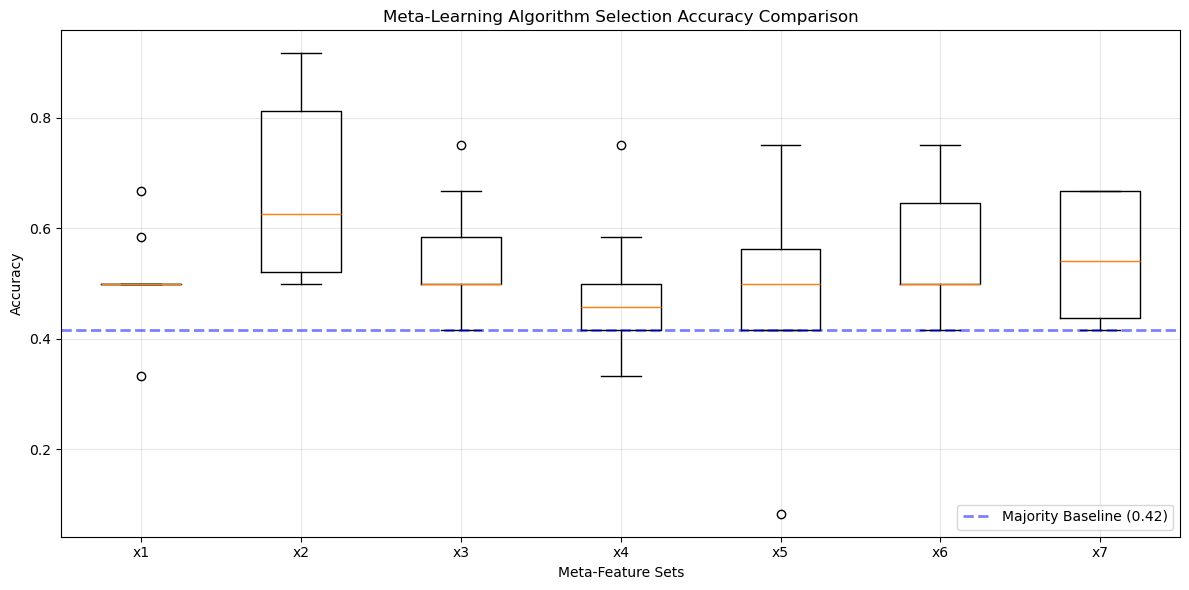

In [47]:
# Boxplot of results
plt.figure(figsize=(12, 6))
plt.boxplot(results.values(), labels=results.keys())

# Title and labels
plt.title('Meta-Learning Algorithm Selection Accuracy Comparison')
plt.xlabel('Meta-Feature Sets')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Plot majority baseline as horizontal line
plt.axhline(majority_accuracy, color='blue', linestyle='--', linewidth=2,
            label=f"Majority Baseline ({majority_accuracy:.2f})", alpha=0.5)

# Show legend
plt.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()


In [48]:
hybrid_datasets = {}

# Deep learning splits (x1-x5) combined with crafted features (x6, x7)
deep_splits = ['x1', 'x2', 'x3', 'x4', 'x5']
crafted_sets = ['x6', 'x7']  # mf1, mf2

hybrid_counter = 8  # Start numbering from x8

for deep_name in deep_splits:
    for crafted_name in crafted_sets:
        # Get the datasets (without target column)
        deep_features = datasets[deep_name].iloc[:, :-1]  # All columns except target
        crafted_features = datasets[crafted_name].iloc[:, :-1]  # All columns except target
        target = datasets[deep_name]['target']  # Target (same for all)
        
        # Combine features horizontally
        hybrid_features = pd.concat([deep_features, crafted_features], axis=1)
        
        # Add target back
        hybrid_df = hybrid_features.copy()
        hybrid_df['target'] = target
        
        # Store with descriptive name
        hybrid_name = f'x{hybrid_counter}'
        hybrid_description = f'{deep_name}+{crafted_name}'
        
        hybrid_datasets[hybrid_name] = hybrid_df
        
        print(f"Created {hybrid_name} ({hybrid_description}): {hybrid_df.shape}")
        print(f"  Deep features: {deep_features.shape[1]} | Crafted features: {crafted_features.shape[1]} | Total: {hybrid_features.shape[1]}")
        
        hybrid_counter += 1

# Add hybrid datasets to main datasets dictionary
datasets.update(hybrid_datasets)

print(f"\n" + "="*60)
print("HYBRID DATASETS CREATED:")
print("="*60)

# Create individual variables for easy access
x8 = datasets['x8']   # x1 + x6 (split-0 + mf1)
x9 = datasets['x9']   # x1 + x7 (split-0 + mf2)
x10 = datasets['x10'] # x2 + x6 (split-1 + mf1)
x11 = datasets['x11'] # x2 + x7 (split-1 + mf2)
x12 = datasets['x12'] # x3 + x6 (split-2 + mf1)
x13 = datasets['x13'] # x3 + x7 (split-2 + mf2)
x14 = datasets['x14'] # x4 + x6 (split-3 + mf1)
x15 = datasets['x15'] # x4 + x7 (split-3 + mf2)
x16 = datasets['x16'] # x5 + x6 (split-4 + mf1)
x17 = datasets['x17'] # x5 + x7 (split-4 + mf2)

# Print summary
combinations = [
    ("x8", "x1 + x6", "split-0 + mf1"),
    ("x9", "x1 + x7", "split-0 + mf2"),
    ("x10", "x2 + x6", "split-1 + mf1"),
    ("x11", "x2 + x7", "split-1 + mf2"),
    ("x12", "x3 + x6", "split-2 + mf1"),
    ("x13", "x3 + x7", "split-2 + mf2"),
    ("x14", "x4 + x6", "split-3 + mf1"),
    ("x15", "x4 + x7", "split-3 + mf2"),
    ("x16", "x5 + x6", "split-4 + mf1"),
    ("x17", "x5 + x7", "split-4 + mf2")
]

for var_name, combo, description in combinations:
    df = datasets[var_name]
    print(f"{var_name}: {df.shape} - {description}")

print(f"\nNow you have 17 total datasets:")
print(f"• x1-x5: Deep learning meta-features (Dataset2Vec)")
print(f"• x6-x7: Traditional crafted meta-features (MF1, MF2)")
print(f"• x8-x17: Hybrid combinations (Deep + Crafted)")

print(f"\nFeature counts:")
print(f"• Deep learning: ~32 features each")
print(f"• Traditional: MF1={datasets['x6'].shape[1]-1}, MF2={datasets['x7'].shape[1]-1}")
print(f"• Hybrid: ~{datasets['x8'].shape[1]-1} features (combined)")

print(f"\nAll datasets ready for train_meta_model_sim() function!")

Created x8 (x1+x6): (120, 74)
  Deep features: 32 | Crafted features: 41 | Total: 73
Created x9 (x1+x7): (120, 55)
  Deep features: 32 | Crafted features: 22 | Total: 54
Created x10 (x2+x6): (120, 74)
  Deep features: 32 | Crafted features: 41 | Total: 73
Created x11 (x2+x7): (120, 55)
  Deep features: 32 | Crafted features: 22 | Total: 54
Created x12 (x3+x6): (120, 74)
  Deep features: 32 | Crafted features: 41 | Total: 73
Created x13 (x3+x7): (120, 55)
  Deep features: 32 | Crafted features: 22 | Total: 54
Created x14 (x4+x6): (120, 74)
  Deep features: 32 | Crafted features: 41 | Total: 73
Created x15 (x4+x7): (120, 55)
  Deep features: 32 | Crafted features: 22 | Total: 54
Created x16 (x5+x6): (120, 74)
  Deep features: 32 | Crafted features: 41 | Total: 73
Created x17 (x5+x7): (120, 55)
  Deep features: 32 | Crafted features: 22 | Total: 54

HYBRID DATASETS CREATED:
x8: (120, 74) - split-0 + mf1
x9: (120, 55) - split-0 + mf2
x10: (120, 74) - split-1 + mf1
x11: (120, 55) - split-1 

In [49]:
for i in range(8, 18):
    dataset = datasets[f'x{i}']
    print(f"Testing x{i} with shape {dataset.shape}...")
    
    accs = train_meta_model_sim(dataset)
    results[f'x{i}'] = accs
    
    print(f"x{i} - Mean accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")

Testing x8 with shape (120, 74)...
x8 - Mean accuracy: 0.5583 ± 0.1239
Testing x9 with shape (120, 55)...
x9 - Mean accuracy: 0.5667 ± 0.1280
Testing x10 with shape (120, 74)...
x10 - Mean accuracy: 0.5000 ± 0.1344
Testing x11 with shape (120, 55)...
x11 - Mean accuracy: 0.5167 ± 0.1041
Testing x12 with shape (120, 74)...
x12 - Mean accuracy: 0.5083 ± 0.1205
Testing x13 with shape (120, 55)...
x13 - Mean accuracy: 0.5083 ± 0.1205
Testing x14 with shape (120, 74)...
x14 - Mean accuracy: 0.4750 ± 0.0917
Testing x15 with shape (120, 55)...
x15 - Mean accuracy: 0.4500 ± 0.1067
Testing x16 with shape (120, 74)...
x16 - Mean accuracy: 0.5333 ± 0.1000
Testing x17 with shape (120, 55)...
x17 - Mean accuracy: 0.5083 ± 0.1146


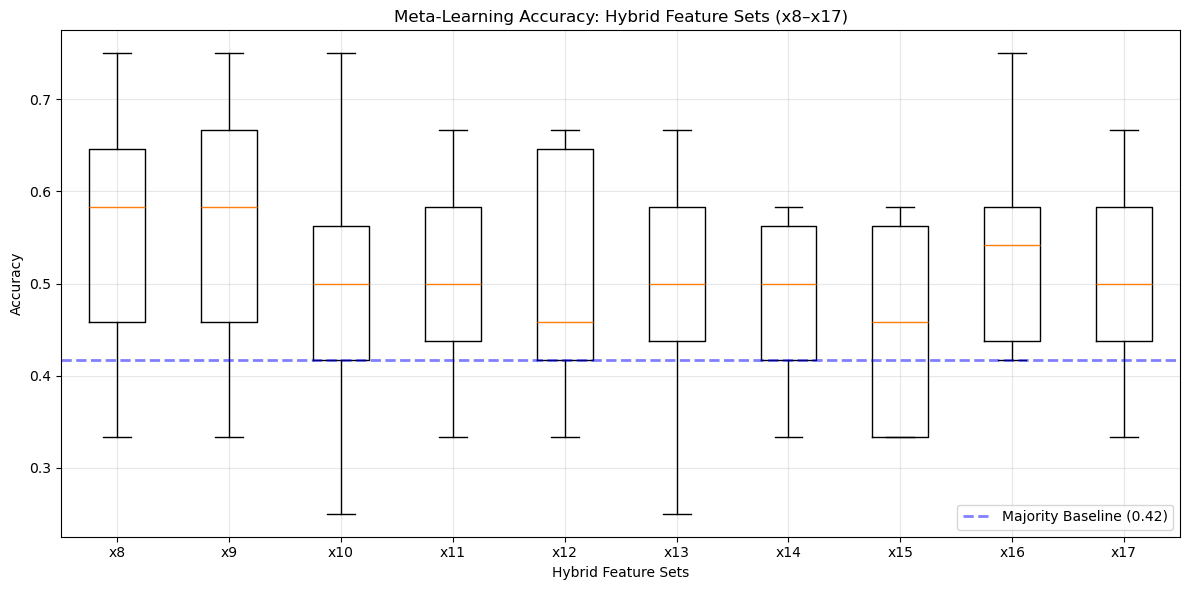

In [50]:
# Filter results for x8 to x17
selected_keys = [f'x{i}' for i in range(8, 18)]
filtered_results = {k: v for k, v in results.items() if k in selected_keys}

# Create boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(filtered_results.values(), labels=filtered_results.keys())

# Title and labels
plt.title('Meta-Learning Accuracy: Hybrid Feature Sets (x8–x17)')
plt.xlabel('Hybrid Feature Sets')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Plot precomputed majority baseline
plt.axhline(majority_accuracy, color='blue', linestyle='--', linewidth=2,
            label=f"Majority Baseline ({majority_accuracy:.2f})", alpha=0.5)

# Show legend and plot
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [51]:
ranked_results = sorted(
    ((key, np.mean(val), np.std(val)) for key, val in results.items()),
    key=lambda x: x[1], reverse=True
)

print("\n=== Ranked Meta-Features by Mean Accuracy ===")
for name, mean_acc, std_acc in ranked_results:
    print(f"{name}: {mean_acc:.4f} ± {std_acc:.4f}")


=== Ranked Meta-Features by Mean Accuracy ===
x2: 0.6667 ± 0.1491
x9: 0.5667 ± 0.1280
x8: 0.5583 ± 0.1239
x6: 0.5500 ± 0.1067
x7: 0.5500 ± 0.1067
x3: 0.5417 ± 0.1003
x16: 0.5333 ± 0.1000
x11: 0.5167 ± 0.1041
x1: 0.5083 ± 0.0786
x12: 0.5083 ± 0.1205
x17: 0.5083 ± 0.1146
x13: 0.5083 ± 0.1205
x10: 0.5000 ± 0.1344
x5: 0.4833 ± 0.1700
x4: 0.4750 ± 0.1181
x14: 0.4750 ± 0.0917
x15: 0.4500 ± 0.1067
